# Automated Essay Scoring

## 1. Business Understanding

Teaching students how to write well is essential since it enables them to convey their ideas, offer arguments that persuade others and ultimately to succeed in their personal and academic endevours [(McNamara, 2015)](https://www.sciencedirect.com/science/article/abs/pii/S1075293514000427). As such, writing exercises such as essays are a powerful tool for evaluating and preparing students in this area. However, grading essays manually is time-consuming and expensive for states. As a result, educational institutions opt in for multiple-choice standardized tests instead . Thus, developing high-fidelity automated essay scoring tools is of utmost importance.

## 2. Exploratory Data Analysis

In [10]:
%reset

In [11]:
import importlib
import matplotlib.pyplot as plt
import pandas as pd
import spacy
import sys
sys.path.append('./src')

import feature_engineering, preprocessing, visualizations
from feature_engineering import extract_coh_metrix_features
from preprocessing import normalize_scores
from visualizations import compare_raters

In [12]:
importlib.reload(feature_engineering)
importlib.reload(preprocessing)
importlib.reload(visualizations)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\setar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<module 'visualizations' from 'd:\\DS_Flat_Iron\\Phase_V\\project\\education_early_intervention\\./src\\visualizations.py'>

In [13]:
df = pd.read_csv('./data/training_set_rel3.tsv', sep='\t', encoding='ISO-8859-1', index_col=0)
df.head(2)

,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,rater1_trait1,...,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
essay_id,,,,,,,,,,,,,,,,,,,,,
1,1,"Dear local newspaper, I think effects computer...",4,4,NaN,8,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,NaN,9,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
df.isna().sum()

essay_set             0
essay                 0
rater1_domain1        0
rater2_domain1        0
rater3_domain1    12848
domain1_score         0
rater1_domain2    11176
rater2_domain2    11176
domain2_score     11176
rater1_trait1     10684
rater1_trait2     10684
rater1_trait3     10684
rater1_trait4     10684
rater1_trait5     12253
rater1_trait6     12253
rater2_trait1     10684
rater2_trait2     10684
rater2_trait3     10684
rater2_trait4     10684
rater2_trait5     12253
rater2_trait6     12253
rater3_trait1     12848
rater3_trait2     12848
rater3_trait3     12848
rater3_trait4     12848
rater3_trait5     12848
rater3_trait6     12848
dtype: int64

In [15]:
cols_to_keep = ['essay_set', 'essay', 'rater1_domain1', 'rater2_domain1', 'domain1_score']
df = df[cols_to_keep]
df.rename(columns={'rater1_domain1':'rater1_score','rater2_domain1':'rater2_score', 'domain1_score':'final_score'}, inplace=True)
df.head()

,essay_set,essay,rater1_score,rater2_score,final_score
essay_id,,,,,
1,1,"Dear local newspaper, I think effects computer...",4,4,8
2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,9
3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4,3,7
4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5,5,10
5,1,"Dear @LOCATION1, I know having computers has a...",4,4,8


### 2.1. Distribution of scores and agreement of human raters
Each set of essays has its own score range (outlined in the code cell below). In order to visualize the distribution of scores for all essays and later on use them as one single training set, we need to normalize the scores. We choose to normalize all scores to the range 0-10 through a linear transformation. 

In [16]:
# min-max range for each essay set
num_essay_sets = len(df['essay_set'].unique())
rubric_range = {
    1: {'rater_min': 1, 'rater_max': 6, 'final_min': 2, 'final_max': 12},
    2: {'rater_min': 1, 'rater_max': 6, 'final_min': 1, 'final_max': 6},
    3: {'rater_min': 0, 'rater_max': 3, 'final_min': 0, 'final_max': 3},
    4: {'rater_min': 0, 'rater_max': 3, 'final_min': 0, 'final_max': 3},
    5: {'rater_min': 0, 'rater_max': 4, 'final_min': 0, 'final_max': 4},
    6: {'rater_min': 0, 'rater_max': 4, 'final_min': 0, 'final_max': 4},
    7: {'rater_min': 0, 'rater_max': 15, 'final_min': 0, 'final_max': 30},
    8: {'rater_min': 0, 'rater_max': 30, 'final_min': 0, 'final_max': 60}
}

In [17]:
for i in range(num_essay_sets):
    mask = df['essay_set'] == i+1
    df.loc[mask, 'rater1_score_norm'] = df.loc[mask].apply(normalize_scores, axis=1, 
                                                            args=('rater1_score', rubric_range[i+1]['rater_min'], rubric_range[i+1]['rater_max']))
    df.loc[mask, 'rater2_score_norm'] = df.loc[mask].apply(normalize_scores, axis=1, 
                                                            args=('rater2_score', rubric_range[i+1]['rater_min'], rubric_range[i+1]['rater_max']))
    df.loc[mask, 'final_score_norm'] = df.loc[mask].apply(normalize_scores, axis=1, 
                                                            args=('final_score', rubric_range[i+1]['final_min'], rubric_range[i+1]['final_max']))
df.head()

,essay_set,essay,rater1_score,rater2_score,final_score,rater1_score_norm,rater2_score_norm,final_score_norm
essay_id,,,,,,,,
1,1,"Dear local newspaper, I think effects computer...",4,4,8,6.0,6.0,6.0
2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,9,8.0,6.0,7.0
3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4,3,7,6.0,4.0,5.0
4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5,5,10,8.0,8.0,8.0
5,1,"Dear @LOCATION1, I know having computers has a...",4,4,8,6.0,6.0,6.0


**Inter-Rater Reliability (IRR):**  
IRR refers to how well raters agree given the same input data. Since we will evaluate the machine learning models based on how well they agree with human raters, it's important to have a benchmark for how well human raters agree among themselves (Ghanta, 2019). In this section, we visualize the agreement between raters 1 and 2 for individual essay sets, as well as all essays. 

Note that normalization of scores and binning them can affect Cohen's Kappa in unexpected ways. Therefore, the Cohen's Kappa is determined for each essay set individually, using the original rubric range. In the end, the mean over all coefficients is used as the average agreement score between human raters. 

Average of Cohen's Kappa is: 0.75
Standard deviation of Cohen's Kappa is: 0.07


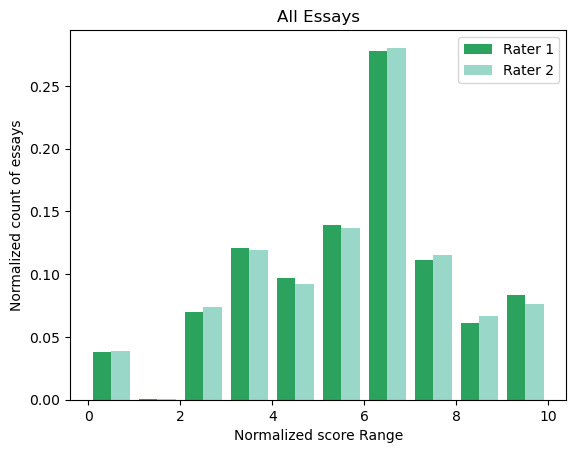

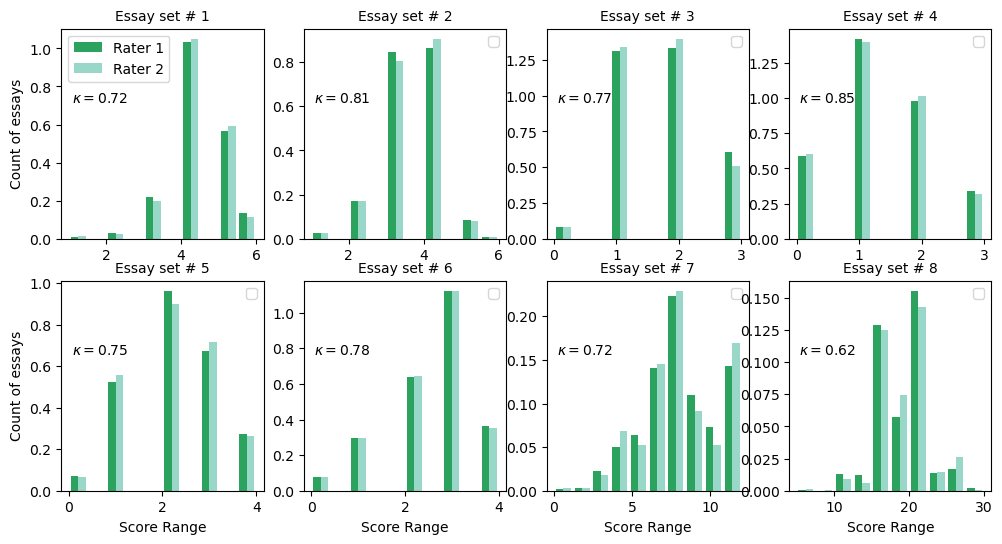

In [18]:
compare_raters(df)

As it can be seen, the average of Kohen's Kappa across all 8 sets of essays is 0.75 $\pm$ 0.07. This indicates substantial agreement among human raters. This baseline is important since we would like to compare the agreement between a human rater with the automated scoring system. 

## 3. Machine Learning Model

### 3.1. Feature Engineering



In [17]:
import importlib
import pandas as pd
import spacy
import textstat
nlp = spacy.load("en_core_web_sm")
text = "This is an example sentence. It is followed by another sentence."
doc = nlp(text)
import sys
sys.path.append('./src')
import feature_engineering
from feature_engineering import extract_coh_metrix_features

In [18]:
importlib.reload(feature_engineering)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\setar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<module 'feature_engineering' from 'd:\\DS_Flat_Iron\\Phase_V\\project\\education_early_intervention\\./src\\feature_engineering.py'>

In [19]:
df = pd.read_csv('./data/training_set_rel3.tsv', sep='\t', encoding='ISO-8859-1')

In [23]:
# extract features for each essay
# establish the dataframe
# include the scores in the dataframe as the target
# train-test split
# scale X
# fit-transform the regression model
# cross-validate, evaluate test scores

In [20]:
my_dict = extract_coh_metrix_features(df.iloc[1]['essay'])

In [22]:
my_dict

{'num_words': 410,
 'num_sentences': 20,
 'avg_sentence_length': 20.5,
 'std_sentence_length': 12.006577144916951,
 'avg_syllable_count': 1.3756097560975609,
 'std_syllable_count': 0.7168187284042866,
 'avg_letter_count': 4.290243902439024,
 'std_letter_count': 2.324768819176552,
 'flesch_reading_ease': 67.08,
 'flesh_kincaid_grade': 9.1,
 'smog_index': 11.8,
 'lexical_diversity': 0.47804878048780486,
 'num_stopwords': 0.47560975609756095,
 'num_pronouns': 0.12195121951219512,
 'num_verbs': 0.16829268292682928,
 'avg_tree_depth': 3.7756097560975608,
 'avg_concreteness': 2.1646341463414633,
 'avg_adj_noun_overlaps': 0.631578947368421,
 'avg_adj_arg_overlaps': 0.6842105263157895,
 'avg_adj_lemma_overlaps': 1.0,
 'lsa_overlap_avg': 0.48565653481437243,
 'lsa_overlap_std': 0.006981780752295202,
 'connectives': 0.04878048780487805,
 'avg_words_before_verb': 3.0,
 'num_misspelled': 0.03170731707317073}

In [18]:
from spacy_syllables import SpacySyllables
nlp.add_pipe("syllables", after="tagger")

nlp = spacy.load("en_core_web_sm")
sentence = nlp('I am a horse. This is funny.')
words_per_sentence = [token.text for token in sentence if token.is_alpha]
sentences = list(sentence.sents)
[token.dep_ for token in sentences[0]]


['nsubj', 'ROOT', 'det', 'attr', 'punct']

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
vectorizer =  TfidfVectorizer()
sents = [sent.text.strip() for sent in sentence.sents if sent.text.strip()]
tfid_mat = vectorizer.fit_transform(sents)
vectorizer.get_feature_names_out()
svd = TruncatedSVD()
lsa_vecs = svd.fit_transform(tfid_mat)
lsa_vecs

array([[1.00000000e+00, 2.15887713e-16],
       [1.12172823e-16, 1.00000000e+00]])

In [55]:
lsa_vecs[0].shape

(2,)

In [56]:
cosine_similarity(lsa_vecs[0].reshape(1,-1), lsa_vecs[1].reshape(1,-1))[0,0]

3.280605364413937e-16

In [57]:
my_dict

{'num_words': 340,
 'num_sentences': 16,
 'avg_sentence_length': 21.25,
 'std_sentence_length': 13.59166411199649,
 'avg_syllable_count': 1.2588235294117647,
 'std_syllable_count': 0.5779210258582909,
 'avg_letter_count': 4.182352941176471,
 'std_letter_count': 2.0686550414157514,
 'flesch_reading_ease': 65.56,
 'smog_index': 10.7,
 'lexical_diversity': 0.4823529411764706,
 'num_stopwords': 0.5323529411764706,
 'num_pronouns': 0.1411764705882353,
 'num_verbs': 0.14705882352941177,
 'avg_tree_depth': 3.614705882352941,
 'avg_concreteness': 2.331794117647059,
 'avg_adj_noun_overlaps': 0.5333333333333333,
 'avg_adj_arg_overlaps': 0.6666666666666666,
 'avg_adj_lemma_overlaps': 0.9333333333333333,
 'connectives': 5,
 'avg_words_before_verb': 4.6}

In [13]:
list(doc.sents)
textstat.flesch_reading_ease(text)
words = [word.text for word in doc if word.is_alpha]

In [9]:
len('paramount')

9

In [15]:
doc

This is an example sentence. It is followed by another sentence.